# Exercício 04 - Implementação de uma ELM

Aluno: Frederico Luis de Azevedo

Professor: Dr. Francisco de Assis Boldt

## Introdução

Neste exercício será implementado uma Extreme Learning Machine para ser comparada com os demais classificadores Perceptron e MLPClassifier. Serão utilizadas quatro base de dados para a comparação.

## Bibliotecas e Inicialização

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.datasets import make_classification, make_gaussian_quantiles
from sklearn.base import BaseEstimator
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

## Bases de dados

Para este exercício serão construídas quatro bases de dados. As duas primeiras utilizam o método `make_classification`.

- Base 1: 100 registros e 50 características
- Base 2: 100 registros e 150 características

As bases 3 e 4 utilizam o método `make_gaussian_quantiles`:

- Base 3: 100 registros e 50 características
- Base 4: 100 registros e 150 características

In [2]:
datasets = [make_classification(n_samples=100, n_features=50),
            make_classification(n_samples=100, n_features=150),
            make_gaussian_quantiles(n_samples=100, n_features=50, n_classes=2),
            make_gaussian_quantiles(n_samples=100, n_features=150, n_classes=2)
            ]

## Implementação da ELM como Classificador

In [3]:
class ELM(BaseEstimator):
    
    def __init__(self):
        self.input_w = []
        self.output_w = []
        self.hidden_units = 1000
        self.binarizer = LabelBinarizer()
        
    def fit(self, x_train, y_train):
        X = self._input_to_hidden(x_train)
        Xt = np.transpose(X)
        self.output_w = np.dot(np.linalg.inv(np.dot(Xt, X)), np.dot(Xt, y_train))
        self.binarizer.fit_transform(y_train)
    
    def predict(self, x_test):
        x = self._input_to_hidden(x_test)
        y = np.dot(x, self.output_w)
        return self.binarizer.inverse_transform(y)
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
    def predict_proba(self, X):
        return self._input_to_hidden(X)

    def _input_to_hidden(self, x):
        self.input_w = np.random.normal(size=[x.shape[1], self.hidden_units])
        a = np.dot(x, self.input_w)
        a = np.maximum(a, 0, a)
        return a

## Treino e teste dos Classificadores

In [4]:
names = ["Perceptron", "Multi-layer Perceptron", "ELM"]

classifiers = [
    Perceptron(),
    MLPClassifier(),
    ELM()]

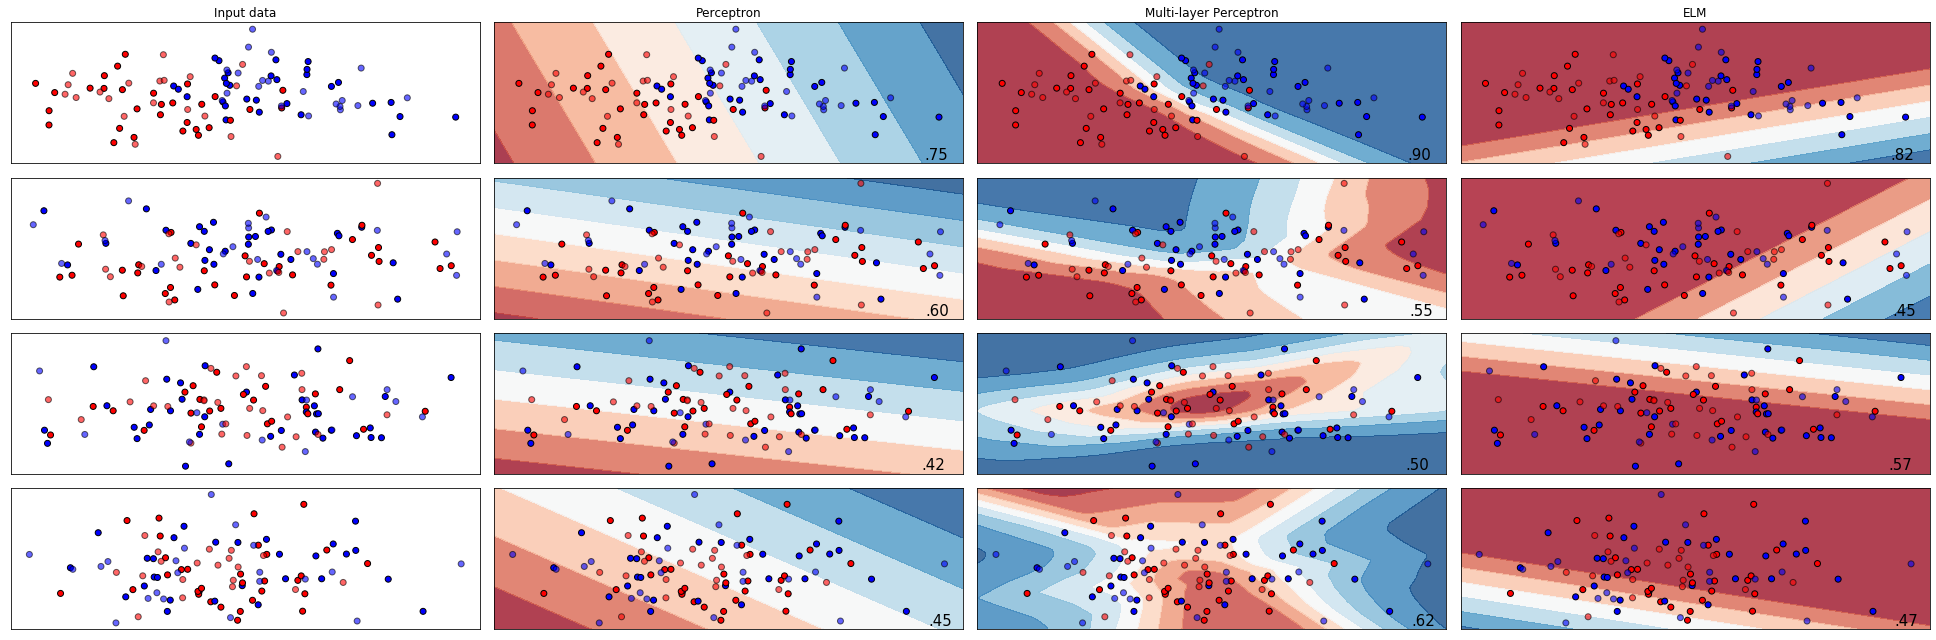

In [5]:
h = .02  # step size in the mesh


figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X = PCA(n_components=2).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [7]:
for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    print('-------- BASE {} --------'.format(ds_cnt+1))
    print(' ')

    for name, clf in zip(names, classifiers):
        start_time = time.time()
        
        scores = cross_val_score(clf, X, y, cv=5)
        print('{:>25}: {}'.format(name, scores))
        print('{:>25}: {}'.format('Mean', scores.mean()))
        print('{:>25}: {}'.format('Std Deviation', scores.std()))
        print('{:>25}: {}'.format('Median', np.median(scores)))
        print('{:>25}: {}'.format('Best', scores.max()))

        elapsed_time = time.time() - start_time
        print('{:>25}: {}'.format('Time Spent (ms)', elapsed_time))
        print(' ')

    print(' ')

-------- BASE 1 --------
 


TypeError: cross_val_score() got an unexpected keyword argument 'return_estimator'

## Resultados

